In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union
from gpytorch.kernels import RBFKernel, MaternKernel
from multiscale_sde.util import softplus_inverse

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import distributions, nn, optim

import torchsde
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# w/ underscore -> numpy; w/o underscore -> torch.
Data = namedtuple('Data', ['ts_', 'ts_ext_', 'ts_vis_', 'ts', 'ts_ext', 'ts_vis', 'ys', 'ys_'])
import sys 
sys.path.append("../..")
lengthscale = 0.2
def make_irregular_gp_data():
    k = MaternKernel(nu=0.5)
    k.lengthscale = lengthscale
    ts = np.concatenate(
        [
            np.random.uniform(low=0.1, high=0.5, size=5),
            np.random.uniform(low=1.5, high=1.9, size=5)
        ],
        axis=0
    )
    ts_ = np.sort(ts)
    ts_ext_ = np.array([0.] + list(ts_) + [2.0])
    ts_vis_ = np.linspace(0., 2.0, 300)
    K = k(torch.Tensor(ts_)).evaluate().double() + (1e-6*torch.eye(ts_.shape[0])).double()
    L = torch.linalg.cholesky(K)
    ys_ = L.detach().cpu().numpy() @ np.random.normal(size=(K.shape[0], 1)).astype(np.float64)

    ts = torch.tensor(ts_).float()
    ts_ext = torch.tensor(ts_ext_).float()
    ts_vis = torch.tensor(ts_vis_).float()
    ys = torch.tensor(ys_).float().to(device)
    return Data(ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_)

def make_data(data_name="irregular_gp"):
    data_constructor = {
        'irregular_gp': make_irregular_gp_data
    }[data_name]
    return data_constructor()

In [3]:
from multiscale_sde.util import softplus_inverse
from multiscale_sde.gp import MaternSDEKernel

In [4]:
def manual_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
manual_seed(0)

In [5]:
# Dataset.
ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_ = make_data()
# Plotting parameters.
vis_batch_size = 1024
ylims = (-3, 3)
alphas = [0.55]
# percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
percentiles = [0.95]
color = "blue"

In [6]:
k = MaternSDEKernel(smoothness=1.5)

In [7]:
ts.shape, ys.shape

(torch.Size([10]), torch.Size([10, 1]))

In [8]:
k.g(ts, ys).shape

torch.Size([10, 2])

In [9]:
method = "euler"
dt = 1e-3
adaptive = False
rtol = 1e-3
atol = 1e-3
adjoint = False
sdeint_fn = torchsde.sdeint_adjoint if adjoint else torchsde.sdeint
kl_anneal_iters = 100
dpi = 300
batch_size=512
train_iters=5000
pause_iters=50
scale=0.01

In [10]:
vis_idx = np.random.permutation(vis_batch_size)
# From https://colorbrewer2.org/.
if color == "blue":
    sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
    fill_color = '#9ebcda'
    mean_color = '#4d004b'
    num_samples = len(sample_colors)
else:
    sample_colors = ('#fc4e2a', '#e31a1c', '#bd0026')
    fill_color = '#fd8d3c'
    mean_color = '#800026'
    num_samples = len(sample_colors)



In [11]:
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val


class EMAMetric(object):
    def __init__(self, gamma: Optional[float] = .99):
        super(EMAMetric, self).__init__()
        self._val = 0.
        self._gamma = gamma

    def step(self, x: Union[torch.Tensor, np.ndarray]):
        x = x.detach().cpu().numpy() if torch.is_tensor(x) else x
        self._val = self._gamma * self._val + (1 - self._gamma) * x
        return self._val

    @property
    def val(self):
        return self._val

In [76]:
def manual_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def _stable_division(a, b, epsilon=1e-7):
    b = torch.where(b.abs().detach() > epsilon, b, torch.full_like(b, fill_value=epsilon) * b.sign())
    return a / b
class LatentSDE(torchsde.SDEIto):

    def __init__(self, smoothness=0.5, variance=1, lengthscale=1, fix_variance=True, fix_lengthscale=True, device="cpu"):
        super(LatentSDE, self).__init__(noise_type="diagonal")
        # define kernel function
        self.kernel = MaternSDEKernel(smoothness=smoothness, variance=variance, lengthscale=lengthscale, fix_variance=fix_variance, fix_lengthscale=fix_lengthscale, device=device)
        self.device = device
        
        # initial distribution p(y0).
        # self.register_buffer("py0_mean", torch.tensor([[0.0]]))
        self.register_buffer("py0_mean", torch.zeros((self.kernel.state_dim())))

        # Approximate posterior drift: Takes in 2 positional encodings and the state.
        self.net = nn.Sequential(
            nn.Linear(2 + self.kernel.state_dim(), 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, self.kernel.state_dim())
        )
        # Initialization trick from Glow.
        self.net[-1].weight.data.fill_(0.)
        self.net[-1].bias.data.fill_(0.)

        # self.qy0_mean = nn.Parameter(torch.tensor([[0.0]]), requires_grad=True)
        # self.qy0_logvar = nn.Parameter(torch.tensor([[logvar]]), requires_grad=True)

        self.qy0_mean = nn.Parameter(torch.zeros((self.kernel.state_dim())), requires_grad=True)
        self.qy0_std_unconstrained = nn.Parameter(softplus_inverse(torch.ones((self.kernel.state_dim()))), requires_grad=True)

    @property
    def qy0_std(self):
        return nn.functional.softplus(self.qy0_std_unconstrained)

    def f(self, t, y):  # Approximate posterior drift.
        if t.dim() == 0:
            t = torch.full_like(y[:,:1], fill_value=t)
        # Positional encoding in transformers for time-inhomogeneous posterior.
        return self.net(torch.cat((torch.sin(t), torch.cos(t), y), dim=-1))

    def g(self, t, y):  # Shared diffusion.
        """Define this using GP Kernel methods
        """
        # return self.sigma.repeat(y.size(0), 1)
        # drift matrix = sigma^2 * sqrt(2 / l) for Matern12 kernel (diffusion of BM is 2/l)
        return self.kernel.g(t, y)
        # return torch.ones(y.size(0), 1, device=self.device) * math.sqrt(2 / (self.lengthscale))

    def h(self, t, y):  # Prior drift.
        """Define this using GP Kernel methods
        """
        return self.kernel.f(t, y)
        # return -1/self.lengthscale * y

    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:, 0:self.kernel.state_dim()]
        f, pseudo_inv, h = self.f(t, y), self.kernel.diffusion_pseudoinverse(y), self.h(t, y)
        # u = _stable_division(f - h, g)

        # pseudo_inv: batch x state_dim
        # f,h: batch x state_dim
        u = pseudo_inv * (f-h)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True)
        return torch.cat([f, f_logqp], dim=1)

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:, 0:self.kernel.state_dim()]
        g = self.g(t, y)
        g_logqp = torch.zeros_like(y[:,:1])
        return torch.cat([g, g_logqp], dim=1)

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.kernel.stationary_covariance().sqrt())
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).

        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=self,
            y0=aug_y0,
            ts=ts,
            method=method,
            dt=dt,
            adaptive=adaptive,
            rtol=rtol,
            atol=atol,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        )
        ys, logqp_path = aug_ys[:, :, 0:-1], aug_ys[-1, :, -1]
        logqp = (logqp0 + logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        out = torch.einsum("ij, tbj -> tbi", self.kernel.measurement_model(), ys)
        return out, logqp

    ### skipping operations
    def forward_skip(self, batch_size, ts_segments, eps=None):

        # suppose we learn the stationary distribution
        eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.kernel.variance.sqrt())
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).
        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        
        for i, ts_segment in enumerate(ts_segments):
            # ts_segment = ts[(ts >= t_starts[i]) & (ts <= t_ends[i])]     
            # ts_segment[0] -= mixing_time
            # ts_segment[-1] += mixing_time
            # ts_segment = ts_segments[i]
            aug_ys = sdeint_fn(
                sde=self,
                y0=aug_y0,
                ts=ts_segment,
                method=method,
                dt=dt,
                adaptive=adaptive,
                rtol=rtol,
                atol=atol,
                names={'drift': 'f_aug', 'diffusion': 'g_aug'}
            )
            ys_segment, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, :1]
            if i == 0:
                ys = ys_segment[1:-1]
            else:
                ys = torch.concat([ys, ys_segment[1:-1]], axis=0)
            eps = torch.randn(batch_size, 1).to(self.qy0_std)
            y0 = self.qy0_mean + eps * self.qy0_std
            aug_y0 = torch.cat([y0, logqp_path], dim=1)
        logqp_path = aug_ys[-1, :, 1]
        logqp = (logqp0 + logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        out = torch.einsum("ij, tbj -> tbi", self.kernel.measurement_model(), ys)
        return out, logqp

    def sample_p(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.py0_mean) if eps is None else eps
        y0 = self.py0_mean + torch.einsum("ij, bj -> bi", self.kernel.stationary_covariance().sqrt(), eps)
        print(y0.shape)
        yt = sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=dt, names={'drift': 'h'})
        out = torch.einsum("ij, tbj -> tbi", self.kernel.measurement_model(), yt)
        return out

    def sample_q(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_mean) if eps is None else eps
        # y0 = self.qy0_mean + eps * self.qy0_std
        y0 = self.qy0_mean + torch.einsum("ij, bj -> bi", self.kernel.stationary_covariance().sqrt(), eps)
        print(y0.shape)
        yt = sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=dt)
        out = torch.einsum("ij, tbj -> tbi", self.kernel.measurement_model(), yt)
        return out


In [77]:
model = LatentSDE(device=device, lengthscale=lengthscale, smoothness=1.5).to(device)
sdeint_fn = torchsde.sdeint


In [105]:
ts, ys = ts.cuda(), ys.cuda()
eps = torch.randn(batch_size, 1).to(model.qy0_std)
y0 = model.qy0_mean + eps * model.qy0_std
aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)


In [106]:
# matern12
model.g(ts, ys.repeat([1,2])).shape, model.f(ts[0], ys.repeat([1,2])).shape, model.f_aug(ts[0], aug_y0).shape, model.g_aug(ts[0], aug_y0).shape

(torch.Size([10, 2]),
 torch.Size([10, 2]),
 torch.Size([512, 3]),
 torch.Size([512, 3]))

In [34]:
eps = torch.randn(vis_batch_size, 1).to(device)  # Fix seed for the random draws used in the plots.
bm = torchsde.BrownianInterval(
    t0=ts_vis[0],
    t1=ts_vis[-1],
    size=(vis_batch_size, 2),
    device=device,
    levy_area_approximation='space-time'
)  # We need space-time Levy area to use the SRK solver

In [35]:
samples = model.sample_p(ts=ts_vis, batch_size=batch_size, eps=eps, bm=bm)

torch.Size([1024, 2])


In [147]:
ts_vis.shape, vis_batch_size

(torch.Size([300]), 1024)

In [20]:
ts_vis.shape, eps.shape

(torch.Size([300]), torch.Size([1024, 1]))

In [36]:
eps = torch.randn(10, 1).to(device)  # Fix seed for the random draws used in the plots.
bm = torchsde.BrownianInterval(
    t0=ts_vis[0],
    t1=ts_vis[-1],
    size=(10, 2),
    device=device,
    levy_area_approximation='space-time'
)  # We need space-time Levy area to use the SRK solver

In [68]:
y0.shape

torch.Size([10, 2])

In [87]:
net =  nn.Sequential(
            nn.Linear(2 + model.kernel.state_dim(), 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, model.kernel.state_dim())

        ).cuda()

In [100]:
t = ts[0]
t = torch.full_like(y0[:,:1], fill_value=t)
# Positional encoding in transformers for time-inhomogeneous posterior.
net(torch.cat((torch.sin(t), torch.cos(t), y0), dim=-1))

tensor([[ 0.0425, -0.0736],
        [ 0.0723, -0.0600],
        [-0.0226, -0.0332],
        [ 0.0245, -0.0587],
        [ 0.0979, -0.0452],
        [ 0.0143, -0.0519],
        [ 0.1106, -0.0420],
        [ 0.0735, -0.0592],
        [-0.0225, -0.0331],
        [ 0.0499, -0.0702]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [83]:
torch.cat((torch.sin(t), torch.cos(t), y0), dim=-1)

tensor([[ 0.2662,  0.9639,  0.1645,  0.1645],
        [ 0.2662,  0.9639,  0.4795,  0.4795],
        [ 0.2662,  0.9639, -0.9585, -0.9585],
        [ 0.2662,  0.9639, -0.1275, -0.1275],
        [ 0.2662,  0.9639,  0.8049,  0.8049],
        [ 0.2662,  0.9639, -0.2612, -0.2612],
        [ 0.2662,  0.9639,  1.0323,  1.0323],
        [ 0.2662,  0.9639,  0.4909,  0.4909],
        [ 0.2662,  0.9639, -0.9536, -0.9536],
        [ 0.2662,  0.9639,  0.2453,  0.2453]], device='cuda:0',
       grad_fn=<CatBackward0>)

In [78]:
model.f(ts[0], y0)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [56]:
samples_q = model.sample_q(ts=ts_vis, batch_size=10, eps=eps[:10], bm=bm)

torch.Size([10, 2])


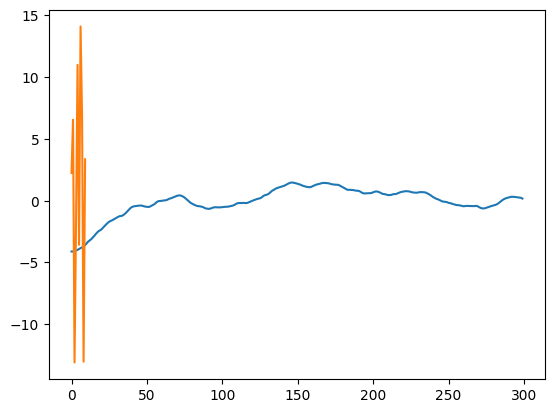

In [63]:
plt.plot(samples.detach().cpu().numpy()[:,3,0])
plt.plot(samples_q.detach().cpu().numpy()[:,3,0])

## plot prior

In [21]:
ckpt_epochs = np.linspace(0, 4950, 100).astype(int)

In [16]:
font = {'weight' : 'bold',
        'size'   : 22}
import matplotlib
matplotlib.rc('font', **font)

In [52]:
t_kl_plot = torch.Tensor(np.linspace(ts_ext[0], ts_ext[-1], 100))
for epoch in ckpt_epochs[-1:]:
    img_path = os.path.join("gp_matern12_viz/", f'prior_step_{epoch}.pdf')
    model.load_state_dict(torch.load(f"gp_matern12_viz/ckpts/global_step_{epoch}.ckpt")["model"])
    with torch.no_grad():
        zs = model.sample_q(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
        samples = zs[:, vis_idx]
        ts_vis_, zs_, samples_ = ts_vis.cpu().numpy(), zs.cpu().numpy(), samples.cpu().numpy()
        zs_ = np.sort(zs_, axis=1)
        fig, (ax1, ax2) = plt.subplots(2, frameon=False, figsize=(20,10), sharex=True)

        for alpha, percentile in zip(alphas, percentiles):
            idx = int((1 - percentile) / 2. * vis_batch_size)
            zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
            ax1.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color, label="Posterior 95%")

        ax1.plot(ts_vis_, zs_.mean(axis=1), color=mean_color, linewidth=2.5)

        for j in range(num_samples):
            ax1.plot(ts_vis_, samples_[:, j], color=sample_colors[j], linewidth=2.5)

        # plot the prior
        zs = model.sample_p(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
        ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
        zs_ = np.sort(zs_, axis=1)
        
        for alpha, percentile in zip(alphas, percentiles):
            idx = int((1 - percentile) / 2. * vis_batch_size)
            zs_bot_ = zs_[:, idx]
            zs_top_ = zs_[:, -idx]
            ax1.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color="C1", label="Prior 95%")

        # plot KL at each point
        eps_normal = torch.randn(batch_size, 1).to(model.qy0_std)
        y0 = model.qy0_mean + eps_normal * model.qy0_std
        qy0 = distributions.Normal(loc=model.qy0_mean, scale=model.qy0_std)
        py0 = distributions.Normal(loc=model.py0_mean, scale=model.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).
        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=model,
            y0=aug_y0,
            ts=t_kl_plot,
            method=method,
            dt=dt,
            adaptive=adaptive,
            rtol=rtol,
            atol=atol,
            bm=None,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'},
        )
        cum_kl = aug_ys[:,:,1].mean(1)
        kl_list = torch.diff(cum_kl)
        ax2.plot(t_kl_plot[1:].cpu().detach().numpy(), kl_list.cpu().detach().numpy(), linewidth=2.5)
        # ax2.plot(ts_, np.zeros_like(ys_), "x", color="black", linewidth=400)
        ax2.scatter(ts_, np.zeros_like(ys_), marker='x', color='black', s=400)  # Data.
        ax2.hlines(0, 0, 2.2, linestyle="--")
    
        ax1.scatter(ts_, ys_, marker='.', color='black', s=400, zorder=2)  # Data.
        ax1.set_ylim(-2, 2)
        ax2.set_ylim(-0.3, 5)
        ax1.legend(loc="lower right")
        ax1.set_xlabel('$t$')
        ax1.set_ylabel('$Y_t$')
        ax2.set_ylabel('KL-Divergence')
        ax2.set_xlim(0, 2)
        # plt.tight_layout()
        plt.savefig(img_path, dpi=dpi)
        plt.close()
        logging.info(f'Saved figure at: {img_path}')

In [22]:
t_kl_plot = torch.Tensor(np.linspace(ts_ext[0], ts_ext[-1], 100))
for epoch in ckpt_epochs[-1:]:
    img_path = os.path.join("gp_matern12_dt1e3_viz/", f'prior_step_{epoch}.pdf')
    model.load_state_dict(torch.load(f"gp_matern12_dt1e3_viz/ckpts/global_step_{epoch}.ckpt")["model"])
    with torch.no_grad():
        zs = model.sample_q(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
        samples = zs[:, vis_idx]
        ts_vis_, zs_, samples_ = ts_vis.cpu().numpy(), zs.cpu().numpy(), samples.cpu().numpy()
        zs_ = np.sort(zs_, axis=1)
        fig, (ax1, ax2) = plt.subplots(2, frameon=False, figsize=(20,10), sharex=True)

        for alpha, percentile in zip(alphas, percentiles):
            idx = int((1 - percentile) / 2. * vis_batch_size)
            zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
            ax1.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color, label="Posterior 95%")

        ax1.plot(ts_vis_, zs_.mean(axis=1), color=mean_color, linewidth=2.5)

        for j in range(num_samples):
            ax1.plot(ts_vis_, samples_[:, j], color=sample_colors[j], linewidth=2.5)

        # plot the prior
        zs = model.sample_p(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
        ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
        zs_ = np.sort(zs_, axis=1)
        
        for alpha, percentile in zip(alphas, percentiles):
            idx = int((1 - percentile) / 2. * vis_batch_size)
            zs_bot_ = zs_[:, idx]
            zs_top_ = zs_[:, -idx]
            ax1.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color="C1", label="Prior 95%")

        # plot KL at each point
        eps_normal = torch.randn(batch_size, 1).to(model.qy0_std)
        y0 = model.qy0_mean + eps_normal * model.qy0_std
        qy0 = distributions.Normal(loc=model.qy0_mean, scale=model.qy0_std)
        py0 = distributions.Normal(loc=model.py0_mean, scale=model.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).
        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=model,
            y0=aug_y0,
            ts=t_kl_plot,
            method=method,
            dt=dt,
            adaptive=adaptive,
            rtol=rtol,
            atol=atol,
            bm=None,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'},
        )
        cum_kl = aug_ys[:,:,1].mean(1)
        kl_list = torch.diff(cum_kl)
        ax2.plot(t_kl_plot[1:].cpu().detach().numpy(), kl_list.cpu().detach().numpy(), linewidth=2.5)
        # ax2.plot(ts_, np.zeros_like(ys_), "x", color="black", linewidth=400)
        ax2.scatter(ts_, np.zeros_like(ys_), marker='x', color='black', s=400)  # Data.
        ax2.hlines(0, 0, 2.2, linestyle="--")
    
        ax1.scatter(ts_, ys_, marker='.', color='black', s=400, zorder=2)  # Data.
        ax1.set_ylim(-2, 2)
        ax2.set_ylim(-0.3, 5)
        ax1.legend(loc="lower right")
        ax1.set_xlabel('$t$')
        ax1.set_ylabel('$Y_t$')
        ax2.set_ylabel('KL-Divergence')
        ax2.set_xlim(0, 2)
        # plt.tight_layout()
        plt.savefig(img_path, dpi=dpi)
        plt.close()
        logging.info(f'Saved figure at: {img_path}')